Following the description by Antonello et al, 2021.

In [1]:
from casadi import *

import matplotlib.pyplot as plt

In [2]:
dt = 0.5

N = 15

opti = Opti()  # optimization problem

In [3]:
X = opti.variable(2,N+1)  # state variables for all k (including 0)
opti.subject_to(opti.bounded(-3,X,3))

U = opti.variable(1,N+1)  # control action
del_U = opti.variable(1,N+1)
opti.subject_to(opti.bounded(-1,U,1))

In [4]:
# objective
N_1 = 1
N_2 = N
N_u = N_2

Q = 10
R = 1

opti.minimize(  # 5a
    (X[0,N_1:N_2+1] @ X[0,N_1:N_2+1].T) * Q + 
    (del_U[:N_u+1] @ del_U[:N_u+1].T) * R
)

In [5]:
# van der pol oscillator
f = lambda x, u: vertcat(x[1], (1 - x[0]**2) * x[1] - x[0] + u)

for k in range(N):  # 5b
    k1 = f(X[:,k],U[:,k])
    k2 = f(X[:,k] + (dt / 2) * k1, U[:,k])
    k3 = f(X[:,k] + (dt / 2) * k1, U[:,k])
    k4 = f(X[:,k] + dt * k3, U[:,k])

    x_next = X[:,k] + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

    opti.subject_to(X[:,k+1] == x_next)

In [6]:
u_prev = 0  # no control applied beforehand
for j in range(N_u+1):  # 5c
    opti.subject_to(
        U[j] == u_prev + del_U[:j+1] @ np.ones(j+1)
    )

In [7]:
# 5d is not necessary as N_u == N_2

In [8]:
# initial conditions
opti.subject_to(X[0,0] == 1.)
opti.subject_to(X[1,0] == 0.)

opti.solver('ipopt')  # set numerical backend
sol = opti.solve()  # actual solve


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:      274
Number of nonzeros in inequality constraint Jacobian.:       48
Number of nonzeros in Lagrangian Hessian.............:      107

Total number of variables............................:       64
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       48
Total number of inequality co

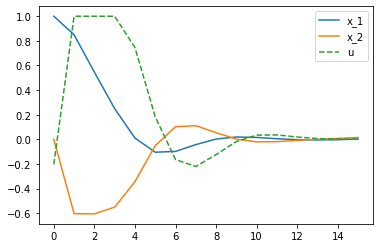

In [9]:
X_sol = sol.value(X)
U_sol = sol.value(U)

plt.plot(X_sol[0], label='x_1')
plt.plot(X_sol[1], label='x_2')
plt.plot(U_sol, '--', label='u')
plt.legend()
plt.show()

# Multiple NMPC runs

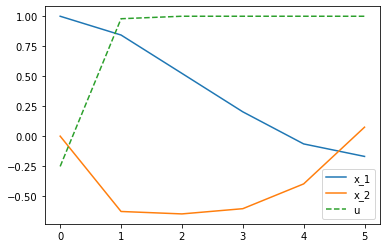

In [10]:
from vdp import get_next

U_sol, X_sol = get_next(X_sol[:,0])

plt.plot(X_sol[0], label='x_1')
plt.plot(X_sol[1], label='x_2')
plt.plot(U_sol, '--', label='u')
plt.legend()
plt.show()

In [11]:
N_all = 20

U_all, X_all = np.zeros(N_all), np.zeros((2,N_all))
X_all[:,0] = [1., 0.]
u_prev = 0
for k in range(N_all):
    U_sol, X_sol = get_next(X_all[:,k], u_prev)

    u_prev = U_sol[0]
    U_all[k] = u_prev
    if k < N_all - 1:  # unless it is the last iteration
        X_all[:,k+1] = X_sol[:,1]

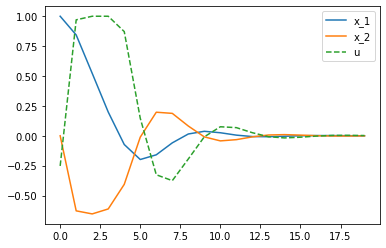

In [12]:
plt.plot(X_all[0], label='x_1')
plt.plot(X_all[1], label='x_2')
plt.plot(U_all, '--', label='u')

plt.legend()
plt.show()

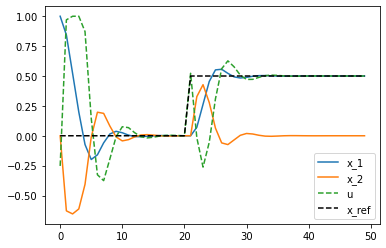

In [16]:
# step response
N_all = 50

U_all, X_all = np.zeros(N_all), np.zeros((2,N_all))
X_all[:,0] = [1., 0.]
u_prev = 0
x_ref = 0
x_refs = list()
for k in range(N_all):
    if k > 20:
        x_ref = 0.5
    x_refs.append(x_ref)

    U_sol, X_sol = get_next(X_all[:,k], u_prev, x_ref)

    u_prev = U_sol[0]
    U_all[k] = u_prev
    if k < N_all - 1:  # unless it is the last iteration
        X_all[:,k+1] = X_sol[:,1]

plt.plot(X_all[0], label='x_1')
plt.plot(X_all[1], label='x_2')
plt.plot(U_all, '--', label='u')
plt.plot(x_refs, '--', c='black', label='x_ref')

plt.legend()
plt.show()

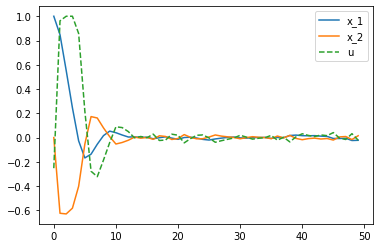

In [30]:
# noisy measurement
N_all = 50

U_all, X_all = np.zeros(N_all), np.zeros((2,N_all))
X_all[:,0] = [1., 0.]
u_prev = 0
for k in range(N_all):
    U_sol, X_sol = get_next(X_all[:,k], u_prev)

    u_prev = U_sol[0]
    U_all[k] = u_prev
    if k < N_all - 1:  # unless it is the last iteration
        # gaussian noise to the measurement
        X_all[:,k+1] = X_sol[:,1] + np.random.normal(scale=0.01)

plt.plot(X_all[0], label='x_1')
plt.plot(X_all[1], label='x_2')
plt.plot(U_all, '--', label='u')

plt.legend()
plt.show()